In [2]:
import pandas as pd
import re
import sklearn as sk
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# file management
import os
import sys

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import gensim
import gensim.downloader as gdownload

# deep learning
import tensorflow as tf
import keras
from keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
print(tf.config.list_physical_devices('GPU')) # check if gpu is detected
from keras import backend as K
import gc


# visualization

import matplotlib.pyplot as plt
from IPython.display import display
# tensorboard
%load_ext tensorboard

[nltk_data] Downloading package wordnet to /home/ashkan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ashkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-08-19 12:35:38.116387: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-19 12:35:38.168199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 12:35:38.911998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
20

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
df = pd.read_csv('./PhishingDataset_HFES2020.csv', encoding='windows-1252')
df = df.replace('ham', 'Ham') # replace ham with Ham
df = df[df['Email_type'] != 'Attention_check'] # remove Attention_check s

# convert labels to numeric
df = df.replace('Phishing', 1) 
df = df.replace('Ham', 0)

display(df.head())
display(df['Email_type'].unique())

,Email_ID,Sender,Subject,Email,Email_type
0,1,noreply@powerballs.com,You Have Won!,<p>*********PLEASE DO NOT RESPOND TO THIS EMAI...,1
1,2,noreply@paypalceo.com,PayPal Breach,<p>********* RESPONES TO THIS EMAIL WILL NOT B...,1
2,3,support@credit.chase.com,URGENT: Fraudulent activity detected,"<p>Hello,&nbsp;</p><p>&nbsp;</p><p>We are writ...",1
3,4,mary@yahoo.com,Donations needed for Mark,"<p>Hello,</p><p>&nbsp;</p><p>I&#39;m contactin...",1
4,5,support@security.amazon.com,Your Amazon Account,<p><strong>The account number associated with ...,1


array([1, 0])

In [10]:
# preprocessin funcs
# preprocessing functions

def text_preprocessing(tweets_list, embedding, maxlen):
    set_stopwords = set(stopwords.words('english'))

    processed_tweets = []
    for i, txt in enumerate(tweets_list):        
        # replace stuff
        txt = re.sub('\b\S*[\x80-\xFF]\S*\b', '', txt) # any words with non-ascii characters
        txt = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', txt) # urls
        txt = re.sub('(?<!\S)@([A-Za-z0-9_]+)(?!\S)', 'USER', txt) # usernames
        # txt = re.sub('#\w+', 'HASHTAG', txt) # hashtags
        txt = re.sub('#', '', txt) # hastags --> just remove the tag
        txt = re.sub('\b\d+\b', 'NUM', txt) # numbers
        txt = re.sub('[^\w\s]', '', txt) # punctuation
        
        # lowercase
        txt = txt.lower()

        # https://saturncloud.io/blog/reshaping-text-data-for-lstm-models-in-keras-a-comprehensive-guide/

        # split
        # nltk handles all punctuation as features
        word_arr = re.split(f'\s+', txt) # returns list of words
    
        # remove stopwords and drop empty strings
        word_arr = [word for word in word_arr if word not in set_stopwords and len(word) != 0]
        
        # lemmatize
        lemmatizer = nltk.stem.WordNetLemmatizer()
        word_arr = [lemmatizer.lemmatize(word) for word in word_arr]

        if i % 10000 == 0: # log the processed message in specified intervals
            print(f"Processed text #{i}:", word_arr)
            print("---------------------------")

        processed_tweets.append(word_arr)
    
    # tokenize (I ditched the old tokenizer)
    print("tokenizing...")
    embedding_length = len(embedding)
    # convert each word to its index. if it doesn't exist, set it to the last index. I don't care that it ruins one word's meaning
    tokenized = [[embedding.key_to_index[word] if word in embedding else (embedding_length - 1) for word in split_sentence] for split_sentence in processed_tweets]

    # add padding and convert to numpy array
    print('padding sequences...')
    tokenized = np.asarray(keras.preprocessing.sequence.pad_sequences(
            tokenized,
            padding = 'post',
            maxlen = maxlen,
    ))

    # DEBUG
    print(tokenized)
    print('feature vector shape:', tokenized.shape)

    return tokenized

# preprocess annotations for initial binary classification
def annotation_preprocessing(annotation_list):
    # set all "threat" to 1, the rest to 0
    return np.asarray([1 if x == "Phishing" else 0 for x in annotation_list])

def train_valid_test_split(ds, train_ratio, valid_ratio, batch_size):
    train_ratio = 0.8
    valid_ratio = 0.1
    init_len = len(ds)
    num_train = np.floor(init_len * train_ratio)
    num_valid = np.floor(init_len * valid_ratio)

    train_ds = ds.take(num_train).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    valid_ds = ds.skip(num_train).take(num_valid).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = ds.skip(num_train).skip(num_valid).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    print(f'train ds has {num_train} items in {len(train_ds)} batches.')
    print(f'valid ds has {num_valid} items in {len(valid_ds)} batches.')
    print(f'test ds has {init_len - num_train - num_valid} items in {len(test_ds)} batches.')

    return (train_ds, valid_ds, test_ds)

def train_and_evaluate(model, train_ds, valid_ds, test_ds, epochs, optimizer, loss):
    model.compile(
        loss = loss,
        optimizer = optimizer,
        metrics = ['acc'],
    )

    print(model.summary())
    history = model.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = epochs,
    )

    # plot losses over time --> shown after training
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.xlabel('accuracy')
    plt.legend(['train','val'], loc='upper left')
    plt.grid()
    plt.ylim(0.5, 1)
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.xlabel('loss')
    plt.legend(['train','val'], loc='upper left')
    plt.grid()
    plt.show()

    # evaluate
    model.evaluate(test_ds)

def tokenize_types(unique_types):
    index_to_type = {index: value for index, value in zip(range(len(unique_types)), unique_types)}
    type_to_index = {value: index for index, value in index_to_type.items()}
    return (index_to_type, type_to_index)

def types_preprocessing(typescol):
    # notes: 
    # I'll just use the first vulnerability type 
    # If the type is "all", I'll drop it from the input

    processed = []
    for string in typescol:
        # print(string)
        string = string.lower() # lowercase
        string = re.sub(r"[,\[\]']", " ", string) # replace [, ], and ' with space
        strlist = string.split() # split list by space
        if 'all' in strlist: strlist.remove('all') # remove the "all" type
        one_type = strlist[0] if len(strlist) > 0 else "empty" # select just the first type

        processed.append(one_type)

    index_to_type, type_to_index = tokenize_types(set(processed))
    # print(type_to_index.items()) # DEBUG

    for i in range(len(processed)):
        processed[i] = type_to_index[processed[i]] # convert each type to index

    return (index_to_type, type_to_index, np.asarray(processed))

def shuffle(nparr, random_state = 42):
    rng = np.random.RandomState(random_state) # reset the seed
    return rng.permutation(nparr)

In [4]:
# get the average length of emails
tweetlengths = df['Email'].apply(lambda x: len(x.split()))
print(np.average(tweetlengths))
# I'll use 100 words

86.2970711297071


In [5]:
# gdownload.info()

In [6]:
# # actual preprocessing
# # embedding = gdownload.load('glove-wiki-gigaword-100') # pretrained embedding --> much cleaner than twitter stuff
# # embedding = gdownload.load('glove-twitter-200') # pretrained embedding --> much cleaner than twitter stuff
# embedding = gdownload.load('glove-twitter-50') # pretrained embedding --> much cleaner than twitter stuff
# # embedding = gdownload.load('word2vec-google-news-300')
# original_texts = np.asarray(df['Email']) # I'll use this to check the preprocessing process

# max_words = 200
# email_bodies = text_preprocessing(df['Email'], embedding, maxlen = max_words) 
# annotation_labels = annotation_preprocessing(df['Email_type'])
# # index_to_type, type_to_index, type_labels = types_preprocessing(df['type'])

# # shuffle the data
# original_texts = shuffle(original_texts) # debug
# email_bodies = shuffle(email_bodies)
# annotation_labels = shuffle(annotation_labels)
# # type_labels = shuffle(type_labels)

# # reduce data for faster training # REMOVE LATER
# ratio_keep = 1 # was 0.2
# original_texts = original_texts[:int(len(original_texts) * ratio_keep)] # debug
# email_bodies = email_bodies[:int(len(email_bodies) * ratio_keep)]
# annotation_labels = annotation_labels[:int(len(annotation_labels) * ratio_keep)]
# # type_labels = type_labels[:int(len(type_labels) * ratio_keep)]

# # DEBUG
# def print_list(title, list):
#     print(title)
#     for i, x in enumerate(list):
#         print(f'<<{i}>>', x)
#     print("------------------------------------------")

# sample_length = 10
# print_list("original data:", original_texts[:sample_length])
# tokenized_input_sample = [[index for index in x] for x in email_bodies][:sample_length]
# print_list("split input: ", [[embedding.index_to_key[index] for index in example] for example in tokenized_input_sample])
# print_list("tokenized input: ", tokenized_input_sample)
# print("labels: ", annotation_labels[:sample_length])


In [15]:
len(df)

239

In [11]:
# create model 1 datasets

email_bodies = df['Email']
binary_labels = df['Email_type']
model1_ds = tf.data.Dataset.from_tensor_slices((email_bodies, binary_labels))
model1_train, model1_valid, model1_test = train_valid_test_split(model1_ds, 0.6, 0.2, 32) 

train ds has 191.0 items in 6 batches.
valid ds has 23.0 items in 1 batches.
test ds has 25.0 items in 1 batches.


In [ ]:
# tfhub bert documentation: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
# bert preprocessing: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

In [3]:
# select a bert model to fine-tune
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [4]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) # the preprocessing is also a tf model

2023-08-19 12:35:42.459823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-19 12:35:42.459914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-19 12:35:42.459942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-19 12:35:43.254417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-19 12:35:43.254515: I tensorflow/compile

In [5]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # tokens of each word
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}') # padding vs actual content
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}') # separates sentences

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
6/6 [==============================] - 24s 3s/step - loss: 0.4217 - binary_accuracy: 0.6545 - val_loss: 3.4130 - val_binary_accuracy: 0.0000e+00
Epoch 2/5
6/6 [==============================] - 20s 3s/step - loss: 0.1455 - binary_accuracy: 0.9738 - val_loss: 5.2773 - val_binary_accuracy: 0.0000e+00
Epoch 3/5
6/6 [==============================] - 20s 3s/step - loss: 0.1430 - binary_accuracy: 0.9738 - val_loss: 5.6690 - val_binary_accuracy: 0.0000e+00
Epoch 4/5
6/6 [==============================] - 19s 3s/step - loss: 0.1427 - binary_accuracy: 0.9738 - val_loss: 5.6059 - val_binary_accuracy: 0.0000e+00
Epoch 5/5
6/6 [==============================] - 18s 3s/step - loss: 0.1420 - binary_accuracy: 0.9738 - val_loss: 5.5315 - val_binary_accuracy: 0.0000e+00
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


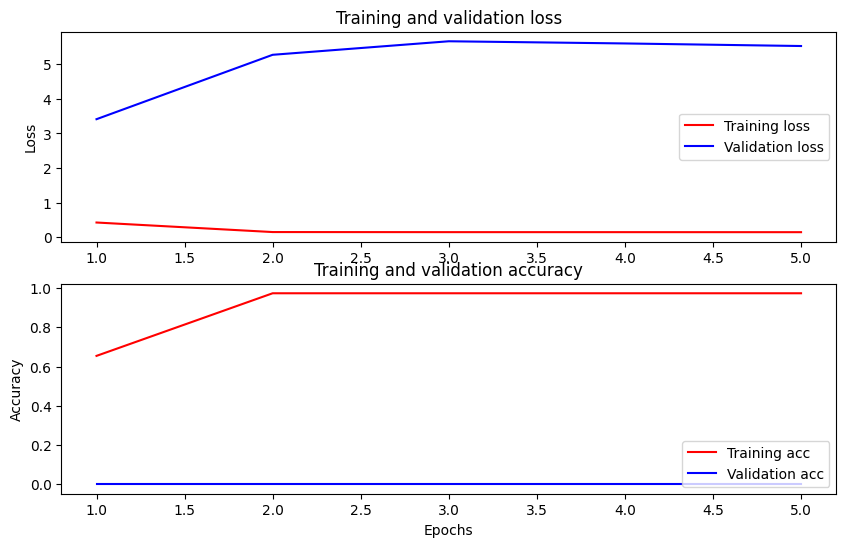

In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(model1_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

classifier_model = build_classifier_model()

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=model1_train,
                               validation_data=model1_valid,
                               epochs=epochs)

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')